# Logit Lens Generation and Visualization

This notebook generates logit lens vectors for images and visualizes them together with image patches.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# Add project root to sys.path so that src/ modules can be imported
current_dir = Path.cwd()
# If launched from notebooks/, go one level up
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    # If launched from the repo root, use the current directory
    project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.HookedLVLM import HookedLVLM
from src.lvlm_lens_gze import create_logit_lens_json_last_layer, embedding_to_word

/root/miniconda/envs/gazeformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [2]:
# Paths (relative to the LogitGaze repo root)
IMAGE_FOLDER = "./data/dataset_images/images_TP"
SAVE_FOLDER = "./data/logit_lens_TP"

# Model parameters
DEVICE = "cuda:0"
QUANTIZE_TYPE = "fp16"

# Logit lens parameters
TOP_K = 5  # Number of top tokens per patch
IMAGE_SIZE = 336  # Image size used by LLaVA
PATCH_SIZE = 14  # Patch size used by LLaVA
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # 576 patches

# Visualization parameters
NUM_VISUALIZE = 5  # Number of patches to visualize
PATCHES_TO_SHOW = [0, 100, 200, 300, 500]  # Patch indices to visualize

## Load model

In [3]:
print("Loading LLaVA model...")
model = HookedLVLM(device=DEVICE, quantize=True, quantize_type=QUANTIZE_TYPE)

# Get components of the underlying language model
language_model = model.model.language_model

# For Llama-based models (like LLaVA uses), the structure might be:
if hasattr(language_model, 'model'):
    # This handles cases like LlamaModel where there's a nested .model
    base_model = language_model.model
elif hasattr(language_model, 'layers') or hasattr(language_model, 'decoder'):
    # Direct access for models that don't have nested .model
    base_model = language_model
else:
    base_model = language_model

# Now access norm correctly
if hasattr(base_model, 'norm'):
    norm = base_model.norm
elif hasattr(language_model, 'norm'):  # Fallback
    norm = language_model.norm
else:
    # Handle different normalization layer names across architectures
    if hasattr(base_model, 'final_layernorm'):  # For some models
        norm = base_model.final_layernorm
    elif hasattr(base_model, 'ln_f'):  # For GPT-style models
        norm = base_model.ln_f
    else:
        raise AttributeError(f"Could not find normalization layer in model: {type(base_model)}")

# For lm_head, try different possible locations
if hasattr(model.model, 'lm_head'):
    lm_head = model.model.lm_head
elif hasattr(language_model, 'lm_head'):
    lm_head = language_model.lm_head
else:
    raise AttributeError("Could not find lm_head in model. Tried model.model.lm_head and language_model.lm_head")

tokenizer = model.processor.tokenizer
model_name = model.model.config._name_or_path.split("/")[-1]
embedding_layer = torch.nn.Embedding.from_pretrained(lm_head.weight)

print(f"Model loaded: {model_name}")
print(f"lm_head found: {type(lm_head)}")

Loading LLaVA model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]
Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Model loaded: llava-1.5-7b-hf
lm_head found: <class 'torch.nn.modules.linear.Linear'>


## Generate logit lens vectors for a single image

In [4]:
# Pick a single example image
from glob import glob
image_files = glob(f"{IMAGE_FOLDER}/**/*.jpg", recursive=True)
if len(image_files) > 0:
    test_image_path = image_files[0]
    print(f"Processing image: {test_image_path}")
    
    # Load image
    image = Image.open(test_image_path).convert("RGB")
    
    # Prompt
    text_question = "First, summarize the image in one sentence. " \
                    "Then, describe each small part of image in detail with objects, textures, and colors."
    prompt = f"USER: <image>\n{text_question} ASSISTANT:"
    
    # Get hidden states
    print("Running forward pass...")
    outputs = model.forward(image, prompt, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    
    # Generate logit lens vectors
    print("Generating logit lens vectors...")
    create_logit_lens_json_last_layer(
        hidden_states, norm, lm_head, tokenizer, embedding_layer, 
        model_name, test_image_path, SAVE_FOLDER,
        top_k=TOP_K, image_size=IMAGE_SIZE, patch_size=PATCH_SIZE, layer='last'
    )
    
    print("Done!")
    
    # Show where files are saved
    img_id = Path(test_image_path).stem
    json_path = Path(SAVE_FOLDER) / "logits" / f"{model_name}_{img_id}_word_vectors.json"
    npy_path = Path(SAVE_FOLDER) / "semantics" / f"{img_id}_word_vectors.npy"
    
    print(f"\n📁 Files saved:")
    print(f"  JSON: {json_path}")
    print(f"  NPY:  {npy_path}")
    print(f"\n📊 Save folder structure:")
    print(f"  {SAVE_FOLDER}/")
    print(f"    ├── logits/      (JSON metadata files)")
    print(f"    └── semantics/   (NPY vector files)")
    
    test_image_path_for_viz = test_image_path
else:
    print("No images found!")
    test_image_path_for_viz = None

Processing image: /repo/dmitriy/logitgaze/gaze_heatmap_predi/Gazeformer_lens/data/dataset_images/images_TP/oven/000000228514.jpg
Running forward pass...
Generating logit lens vectors...
Done!


## Visualization of patches and words

## Generate logit lens vectors for all images

In [ ]:
# Generate logit lens vectors for all images in a folder
def process_all_images(image_folder, save_folder, model, norm, lm_head, tokenizer, embedding_layer, 
                       model_name, top_k=5, image_size=336, patch_size=14, num_images=None):
    """
    Process all images in a folder and generate logit lens vectors.
    
    Args:
        image_folder: Path to the image folder
        save_folder: Path where results will be saved
        model: Loaded HookedLVLM model
        norm: Normalization layer
        lm_head: Language model head
        tokenizer: Tokenizer
        embedding_layer: Embedding layer
        model_name: Name of the model
        top_k: Number of top tokens per patch
        image_size: Image size
        patch_size: Patch size
        num_images: Number of images to process (None = all)
    """
    from glob import glob
    from tqdm import tqdm
    from collections import Counter
    
    # Collect all images
    image_files = glob(f"{image_folder}/**/*.jpg", recursive=True)
    if not image_files:
        image_files = glob(f"{image_folder}/**/*.png", recursive=True)
    
    if not image_files:
        print(f"No images found in {image_folder}")
        return
    
    if num_images:
        image_files = image_files[:num_images]
    
    print(f"Found {len(image_files)} images to process")
    
    # Prompt
    text_question = "First, summarize the image in one sentence. " \
                    "Then, describe each small part of image in detail with objects, textures, and colors."
    prompt = f"USER: <image>\n{text_question} ASSISTANT:"
    
    successful = 0
    failed = 0
    
    for image_path in tqdm(image_files, desc="Processing images"):
        try:
            # Load image
            image = Image.open(image_path).convert("RGB")
            
            # Get hidden states
            outputs = model.forward(image, prompt, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            
            # Generate logit lens vectors
            create_logit_lens_json_last_layer(
                hidden_states, norm, lm_head, tokenizer, embedding_layer, 
                model_name, image_path, save_folder,
                top_k=top_k, image_size=image_size, patch_size=patch_size, layer='last'
            )
            successful += 1
            
        except Exception as e:
            print(f"\nError processing {image_path}: {e}")
            failed += 1
            continue
    
    print(f"\n✅ Processing complete!")
    print(f"  Successful: {successful}")
    print(f"  Failed: {failed}")
    print(f"  Total: {len(image_files)}")
    
    # Show where files are saved
    print(f"\n📁 Files saved to:")
    print(f"  {save_folder}/")
    print(f"    ├── logits/      (JSON metadata files)")
    print(f"    └── semantics/   (NPY vector files)")
    
    # Statistics for saved files
    logits_folder = Path(save_folder) / "logits"
    semantics_folder = Path(save_folder) / "semantics"
    
    if logits_folder.exists():
        json_files = list(logits_folder.glob("*.json"))
        print(f"\n📊 Statistics:")
        print(f"  JSON files: {len(json_files)}")
        
        if semantics_folder.exists():
            npy_files = list(semantics_folder.glob("*.npy"))
            print(f"  NPY files: {len(npy_files)}")
            
            # Inspect one file for detailed stats
            if len(json_files) > 0:
                import json
                with open(json_files[0], 'r') as f:
                    sample_data = json.load(f)
                
                print(f"\n📈 Sample file statistics ({Path(json_files[0]).name}):")
                print(f"  Image: {Path(sample_data['image_filename']).name}")
                print(f"  Patches: {sample_data['num_patches']}")
                print(f"  Patch size: {sample_data['patch_size']}x{sample_data['patch_size']}")
                print(f"  Image size: {sample_data['image_size']}x{sample_data['image_size']}")
                print(f"  Vector shape: {sample_data['word_vectors_shape']}")
                print(f"  Layer used: {sample_data['layer_used']} (total layers: {sample_data['total_layers']})")
                
                # Token statistics
                all_tokens = []
                for patch_data in sample_data['last_layer_data']:
                    all_tokens.extend(patch_data['tokens'])
                
                from collections import Counter
                token_counts = Counter(all_tokens)
                print(f"\n🔤 Top 10 most common words across all patches:")
                for token, count in token_counts.most_common(10):
                    clean_token = token.replace('▁', ' ').strip()
                    print(f"  {clean_token}: {count} times")
                
                # Load NPY file for vector statistics
                npy_file = semantics_folder / sample_data['word_vectors_file']
                if npy_file.exists():
                    vectors = np.load(npy_file)
                    print(f"\n📐 Vector statistics:")
                    print(f"  Shape: {vectors.shape}")
                    print(f"  Mean: {vectors.mean():.4f}")
                    print(f"  Std: {vectors.std():.4f}")
                    print(f"  Min: {vectors.min():.4f}")
                    print(f"  Max: {vectors.max():.4f}")

# Run generation for all images
# Uncomment the following line to run on the full dataset:
# process_all_images(
#     IMAGE_FOLDER, 
#     SAVE_FOLDER, 
#     model, 
#     norm, 
#     lm_head, 
#     tokenizer, 
#     embedding_layer, 
#     model_name,
#     top_k=TOP_K,
#     image_size=IMAGE_SIZE,
#     patch_size=PATCH_SIZE,
#     num_images=None  # None = all images, or set a limit (e.g., 10)
# )

# Example: generation for the first 10 images (for testing)
# process_all_images(
#     IMAGE_FOLDER, 
#     SAVE_FOLDER, 
#     model, 
#     norm, 
#     lm_head, 
#     tokenizer, 
#     embedding_layer, 
#     model_name,
#     top_k=TOP_K,
#     image_size=IMAGE_SIZE,
#     patch_size=PATCH_SIZE,
#     num_images=10
# )

/tmp/ipykernel_164311/955481949.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/root/miniconda/envs/gazeformer/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


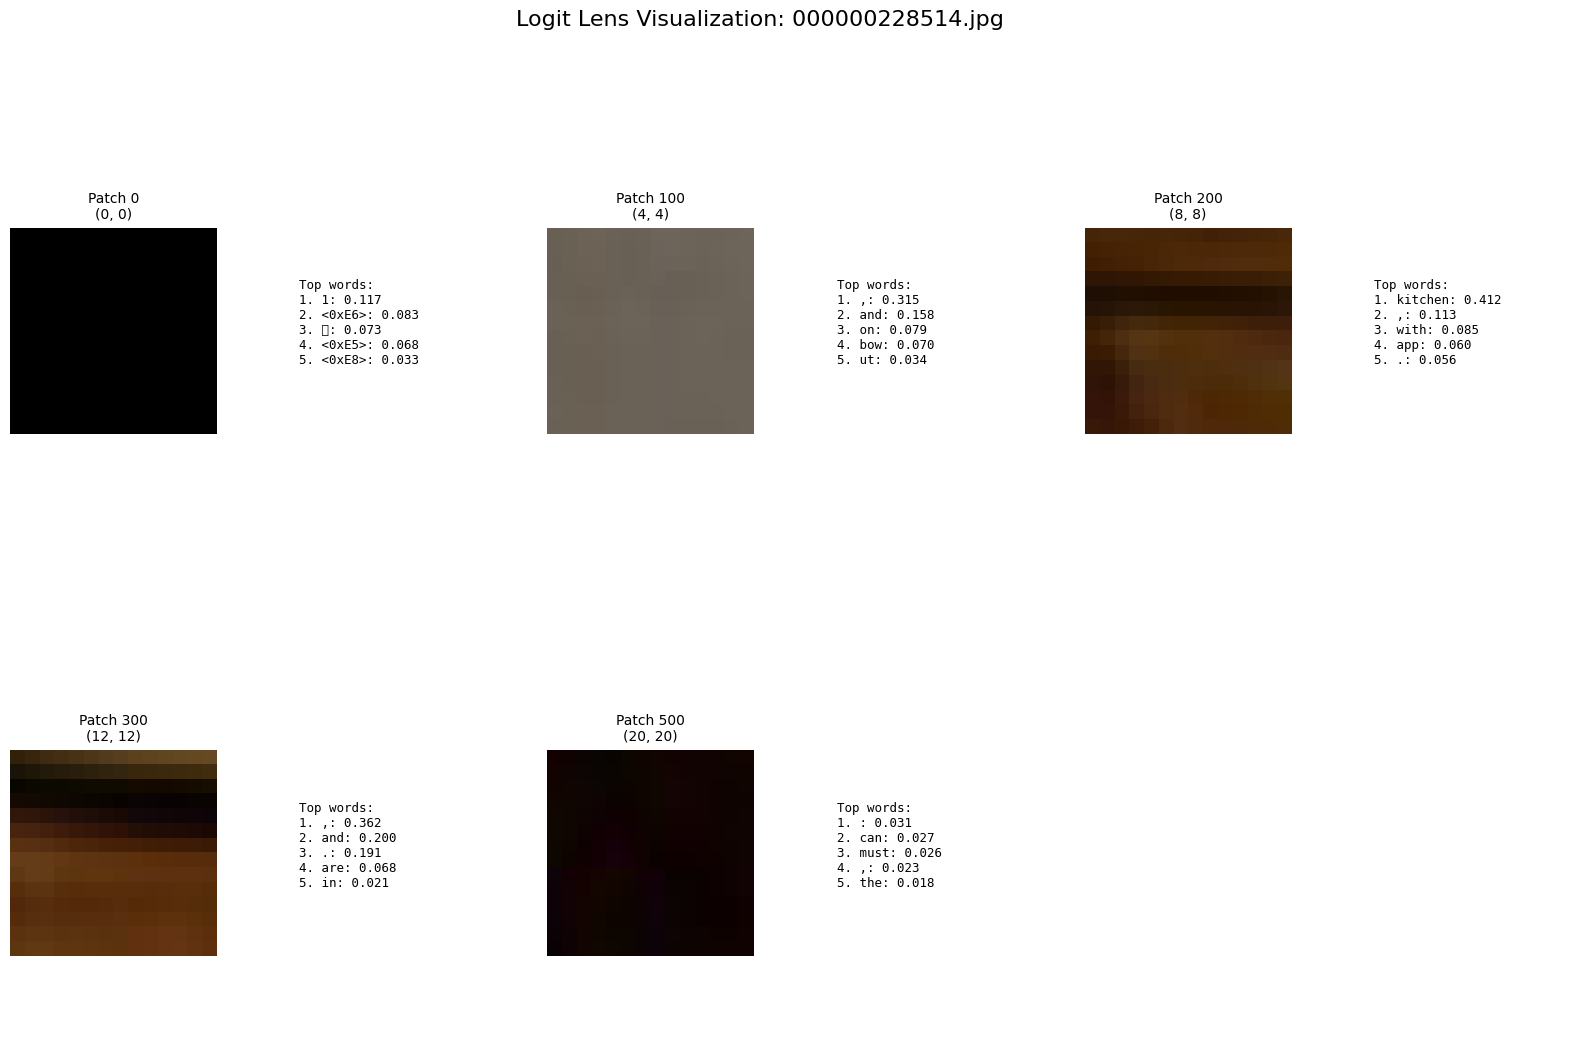

In [5]:
def visualize_patches_with_words(image_path, json_path, npy_path, patches_to_show=None, num_patches_per_row=3):
    """
    Visualize image patches together with the corresponding logit lens words.
    """
    import json
    
    # Load metadata and vectors
    image = Image.open(image_path).convert("RGB")
    with open(json_path, 'r') as f:
        logit_data = json.load(f)
    word_vectors = np.load(npy_path)
    
    # Determine which patches to visualize
    if patches_to_show is None:
        num_patches = len(logit_data['last_layer_data'])
        patches_to_show = list(range(0, min(num_patches, 9)))
    
    num_patches_to_show = len(patches_to_show)
    num_rows = (num_patches_to_show + num_patches_per_row - 1) // num_patches_per_row
    
    # Create figure with the original image on top
    fig = plt.figure(figsize=(20, 4 + 6 * num_rows))
    gs = GridSpec(num_rows + 1, num_patches_per_row * 2, figure=fig, hspace=0.4, wspace=0.3, height_ratios=[1] + [1]*num_rows)
    
    # Show the original image on top
    ax_original = fig.add_subplot(gs[0, :])
    ax_original.imshow(image)
    ax_original.set_title(f"Original Image: {Path(image_path).name}", fontsize=12, fontweight='bold')
    ax_original.axis('off')
    
    # Patch parameters
    num_patches_per_axis = IMAGE_SIZE // PATCH_SIZE
    
    for idx, patch_idx in enumerate(patches_to_show):
        row = idx // num_patches_per_row
        col = (idx % num_patches_per_row) * 2
        
        # Compute patch coordinates
        patch_row = patch_idx // num_patches_per_axis
        patch_col = patch_idx % num_patches_per_axis
        
        y_start = patch_row * PATCH_SIZE
        y_end = y_start + PATCH_SIZE
        x_start = patch_col * PATCH_SIZE
        x_end = x_start + PATCH_SIZE
        
        # Highlight the patch on the original image
        from matplotlib.patches import Rectangle
        rect = Rectangle((x_start, y_start), PATCH_SIZE, PATCH_SIZE, 
                        linewidth=2, edgecolor='red', facecolor='none')
        ax_original.add_patch(rect)
        
        # Show the patch crop
        ax_patch = fig.add_subplot(gs[row + 1, col])
        patch_image = image.crop((x_start, y_start, x_end, y_end))
        ax_patch.imshow(patch_image)
        ax_patch.set_title(f"Patch {patch_idx}\nRow: {patch_row}, Col: {patch_col}", fontsize=10)
        ax_patch.axis('off')
        
        # Show the associated tokens
        ax_words = fig.add_subplot(gs[row + 1, col + 1])
        ax_words.axis('off')
        
        if patch_idx < len(logit_data['last_layer_data']):
            patch_data = logit_data['last_layer_data'][patch_idx]
            tokens = patch_data['tokens'][:TOP_K]
            probs = patch_data['probs'][:TOP_K]
            
            words_text = "Top words:\n"
            for i, (token, prob) in enumerate(zip(tokens, probs)):
                # Clean token from special characters
                clean_token = token.replace('▁', ' ').strip()
                words_text += f"{i+1}. {clean_token}: {prob:.3f}\n"
            
            ax_words.text(0.1, 0.5, words_text, fontsize=9, verticalalignment='center',
                         family='monospace', transform=ax_words.transAxes)
        else:
            ax_words.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax_words.transAxes)
    
    plt.suptitle(f"Logit Lens Visualization: {Path(image_path).name}", fontsize=16, y=0.995)
    return fig

# Visualize patches and words
if 'test_image_path_for_viz' in locals() and test_image_path_for_viz is not None:
    img_id = Path(test_image_path_for_viz).stem
    json_path = Path(SAVE_FOLDER) / "logits" / f"{model_name}_{img_id}_word_vectors.json"
    npy_path = Path(SAVE_FOLDER) / "semantics" / f"{img_id}_word_vectors.npy"
    
    if json_path.exists() and npy_path.exists():
        fig = visualize_patches_with_words(
            test_image_path_for_viz, 
            str(json_path), 
            str(npy_path),
            patches_to_show=PATCHES_TO_SHOW
        )
        plt.show()
    else:
        print(f"Files not found: {json_path}, {npy_path}")
else:
    print("No test image processed yet. Run the generation cell first.")